# 6. Calibration of double ended measurement with OLS

A double ended calibration is performed with ordinary least squares. Over all timesteps simultaneous. $\gamma$ and $\int_0^l\alpha$d$x$ remain constant, while $C$ varies over time. The weights are considered equal here and no variance is calculated.

Before starting the calibration procedure, the forward and the backward channel should be aligned.

In [1]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'double_ended2')

ds = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds100 = ds.sel(x=slice(0, 100))  # only calibrate parts of the fiber
sections = {
    'probe1Temperature': [slice(7.5, 17.), slice(70., 80.)],  # cold bath
    'probe2Temperature': [slice(24., 34.), slice(85., 95.)],  # warm bath
    }

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
The measurement is double ended
Reading the data from disk


In [3]:
print(ds100.calibration_double_ended.__doc__)



        Parameters
        ----------
        store_p_cov : str
            Key to store the covariance matrix of the calibrated parameters
        store_p_val : str
            Key to store the values of the calibrated parameters
        p_val : array-like, optional
        p_var : array-like, optional
        p_cov : array-like, optional
        sections : dict, optional
        st_label : str
            Label of the forward stokes measurement
        ast_label : str
            Label of the anti-Stoke measurement
        rst_label : str
            Label of the reversed Stoke measurement
        rast_label : str
            Label of the reversed anti-Stoke measurement
        st_var : float, optional
            The variance of the measurement noise of the Stokes signals in
            the forward
            direction Required if method is wls.
        ast_var : float, optional
            The variance of the measurement noise of the anti-Stokes signals
            in the forwar

In [4]:
st_label = 'ST'
ast_label = 'AST'
rst_label = 'REV-ST'
rast_label = 'REV-AST'
ds100.calibration_double_ended(sections=sections,
                               st_label=st_label,
                               ast_label=ast_label,
                               rst_label=rst_label,
                               rast_label=rast_label,
                               method='ols')

After calibration, two data variables are added to the `DataStore` object:
- `TMPF`, temperature calculated along the forward direction
- `TMPB`, temperature calculated along the backward direction

A better estimate, with a lower expected variance, of the temperature along the fiber is the average of the two. We cannot weigh on more than the other, as we do not have more information about the weighing.

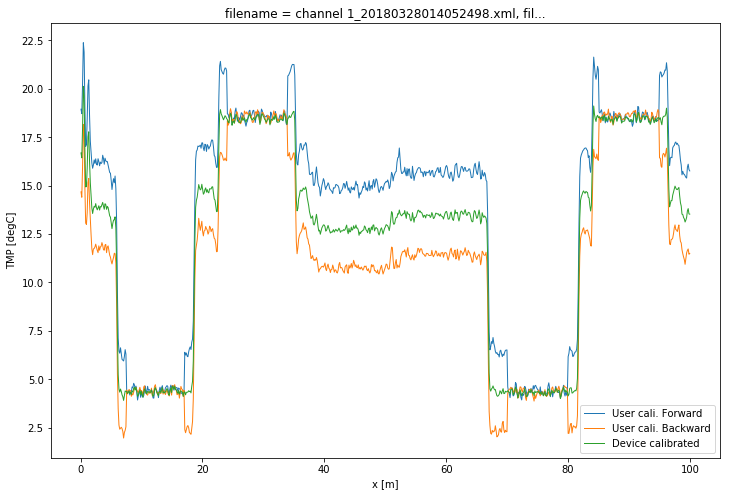

In [5]:
ds1 = ds100.isel(time=0)  # take only the first timestep

ds1.TMPF.plot(linewidth=1, label='User cali. Forward', figsize=(12, 8))  # plot the temperature calibrated by us
ds1.TMPB.plot(linewidth=1, label='User cali. Backward')  # plot the temperature calibrated by us
ds1.TMP.plot(linewidth=1, label='Device calibrated')  # plot the temperature calibrated by the device
plt.legend();

Lets compare our calibrated values with the device calibration. Lets average the temperature of the forward channel and the backward channel first.

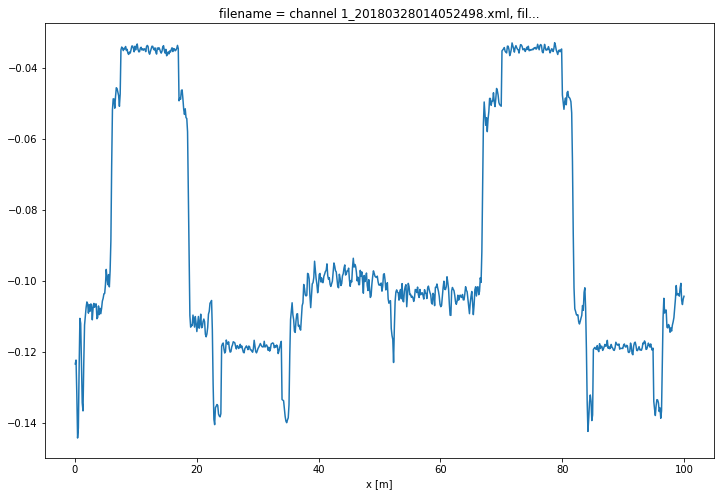

In [6]:
ds1['TMPAVG'] = (ds1.TMPF + ds1.TMPB) / 2
ds1_diff = ds1.TMP - ds1.TMPAVG

ds1_diff.plot(figsize=(12, 8));

The device calibration sections and calibration sections defined by us differ. The device only allows for 2 sections, one per thermometer. And most likely the $\gamma$ is fixed in the device calibration.